In [1]:
import os
import numpy as np
def get_filelist(home_dir):
    filelist = []
    for dirpath, dirnames, filenames in os.walk(home_dir):
        for filename in filenames:
            fn = os.path.join(dirpath,filename)
            filelist.append(fn)
    filelist = sorted(filelist)
    return filelist

depthlist = get_filelist('cloth/depth')
rgblist = get_filelist('cloth/rgb')

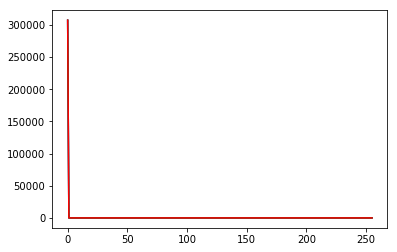

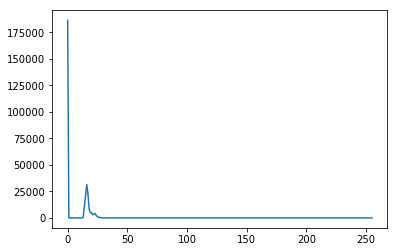

In [35]:
import cv2
import matplotlib.pyplot as plt

i = 1
depth = cv2.imread(depthlist[i])

color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([depth],[i],None,[256],[0,8000])
    plt.plot(histr,color = col)

plt.show()

gray = cv2.cvtColor(depth,cv2.COLOR_BGR2GRAY)
hist = cv2.calcHist([gray],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()


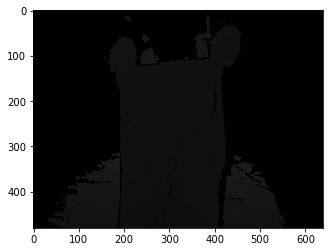

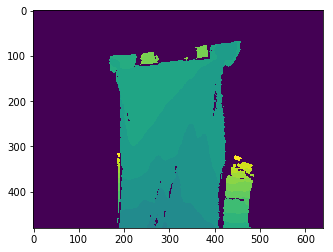

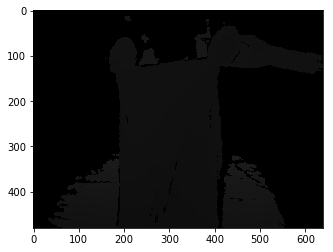

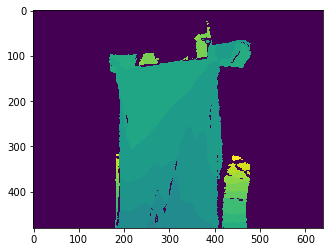

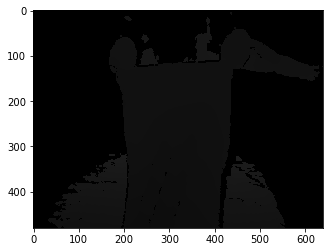

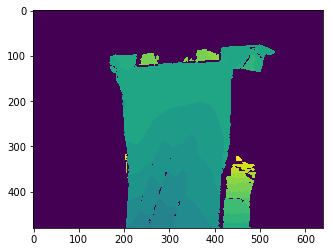

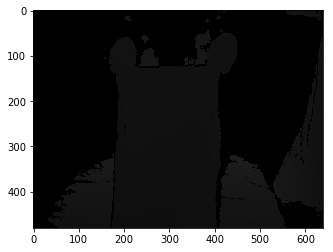

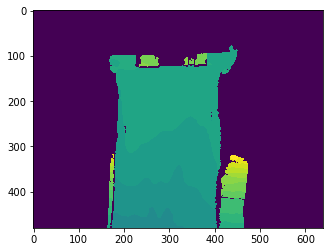

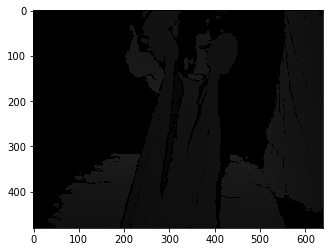

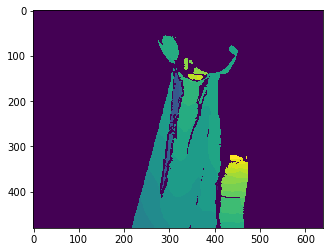

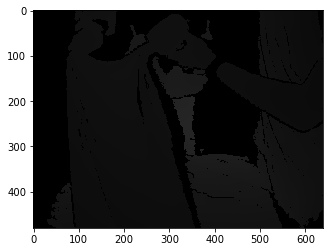

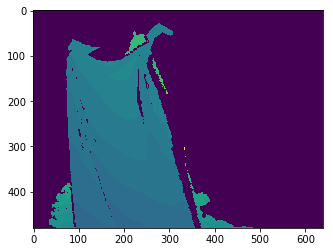

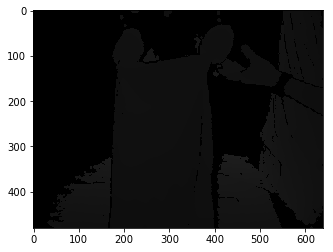

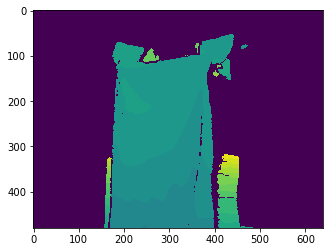

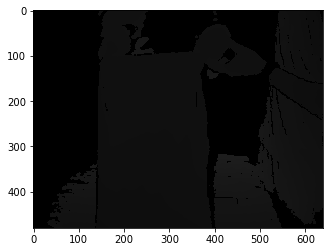

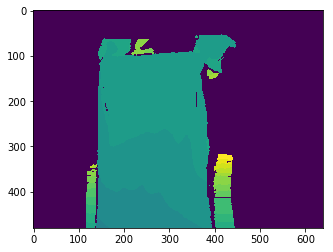

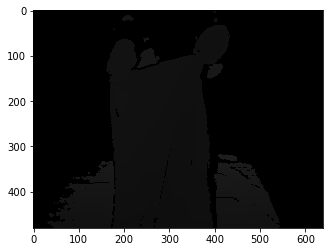

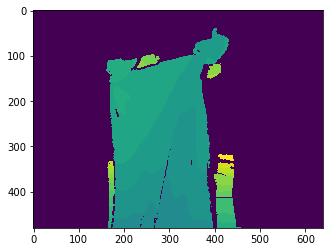

In [24]:
i = 1
def get_fg(img):
    markers = np.uint8(np.zeros((480,640)))
    markers[420:, 280:360] =1
    # set background as 2
    markers[:,0:20] = 2
    markers[:,-20:] = 2
    markers[0:20,:] = 2
    markers_rgb = markers.astype(np.int32)
    markers_rgb = cv2.watershed(img,markers_rgb)
    fg = np.uint8(markers_rgb == 1)
    return fg

def mk(s):#morph kernel
    return np.ones((s,s),np.uint8)

def shrink(fg):
    shrink_fg = cv2.erode(fg, mk(15), iterations = 2)
    return shrink_fg

for i in range(0,len(depthlist),200):
    depth = cv2.imread(depthlist[i])
    plt.imshow(depth), plt.show()
    rgb = cv2.imread(rgblist[i])
    fg = get_fg(rgb)
    #fg = shrink(fg)
    gray = cv2.cvtColor(depth,cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_and(gray,gray,mask = fg)
    plt.imshow(gray)
    plt.show()
    

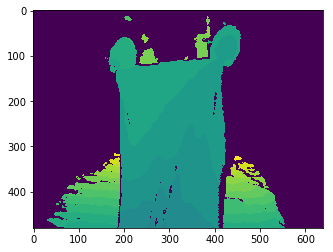

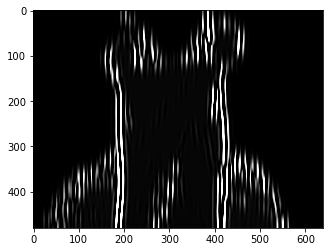

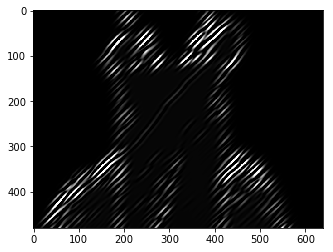

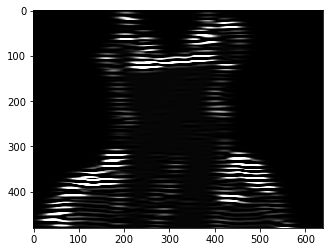

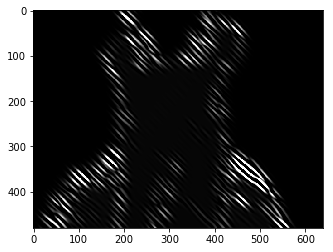

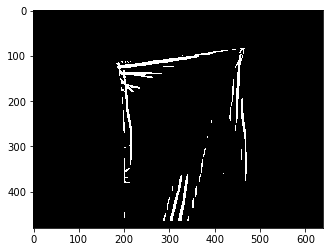

(<matplotlib.image.AxesImage at 0x7fdf01aaa190>, None)

In [31]:
def gabor_feat(img, num_theta = 4, show_fg=False,show_step=False):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fg = get_fg(img)
    shrink_fg = cv2.erode(fg, mk(15), iterations = 2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_and(gray, gray, mask = fg)
    if show_fg:
        plt.imshow(gray,cmap='gray')
        plt.show()
    
    ks = 101 # kernel size
    thresh = 200
    
    avg = np.zeros(gray.shape, dtype=bool)
    count = 0
    
    hist = []
    for i in range(num_theta):
        g_kernel1 = cv2.getGaborKernel((ks, ks), sigma = 6.0, theta = i*np.pi/num_theta, lambd = 10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F)
        filtered = cv2.filter2D(gray, cv2.CV_8UC3, g_kernel1)
        count = count+1
        
        filtered = np.array(filtered>thresh, dtype=bool)
        filtered = filtered & shrink_fg
        avg = avg | filtered
        hist.append(np.sum(filtered>0))
        if show_step:
            plt.imshow(filtered)
            plt.show()
            
    return avg, hist

i = 1
depth = cv2.imread(depthlist[i])
rgb = cv2.imread(rgblist[i])
gray = cv2.cvtColor(depth,cv2.COLOR_BGR2GRAY)
plt.imshow(gray),plt.show()

img = gray.copy()
# sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
# sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5) 
# laplacian = cv2.Laplacian(img,cv2.CV_64F)
kernel = np.ones((5,5),np.float32)/25
ret = cv2.filter2D(img,-1,kernel)

ks = 200
num_theta = 4

for i in range(num_theta):
    g_kernel1 = cv2.getGaborKernel((ks, ks), sigma = 6.0, theta = i*np.pi/num_theta, lambd = 10.0, gamma=0.5, psi=0, ktype=cv2.CV_32F)
    filtered = cv2.filter2D(gray, cv2.CV_8UC3, g_kernel1)
    plt.imshow(filtered, cmap = 'gray'), plt.show()

gabor,_ = gabor_feat(rgb)
plt.imshow(gabor, cmap='gray'), plt.show()